In [89]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML, display
from typing import List, Optional
import pandas as pd

class RandomWalkAnimator:
    def __init__(self, N: int, C: int, interval: int = 250, seed: Optional[int] = None, strategy: str = "original"):
        self.N = N
        self.C = C
        self.interval = interval
        self.seed = seed
        self.strategy = strategy
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self.G = self._generate_connected_graph()
        self.pos = nx.spring_layout(self.G, seed=seed)
        self.walk_sequence = self._generate_walk_sequence(self.G)

    # Helper function for switching walk strategies
    def _generate_walk_sequence(self, G: nx.Graph, start_node=None) -> List[int]:
        if self.strategy == "smart":
            return self._smart_random_walk_sequence(G, start_node)
        else:
            return self._random_walk_sequence(G, start_node)


    def _generate_connected_graph(self) -> nx.Graph:
        for _ in range(100):  # max attempts
            G = nx.gnm_random_graph(self.N, self.C)
            if nx.is_connected(G):
                return G
        raise ValueError(f"Failed to generate a connected graph with N={self.N}, C={self.C}")


    def _random_walk_sequence(self, G: nx.Graph, start_node=None) -> List[int]:
        if start_node is None:
            start_node = random.choice(list(G.nodes))
        visited = set([start_node])
        current = start_node
        sequence = [start_node]
        while len(visited) < len(G.nodes):
            neighbors = list(G.adj[current])
            if not neighbors:
                break
            current = random.choice(neighbors)
            sequence.append(current)
            visited.add(current)
        return sequence

    def create_animation(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        fig.suptitle(f"Random Walk on a Graph with N={self.N}, C={self.C}", fontsize=16)
        ax.axis('off')
        nx.draw_networkx_edges(self.G, self.pos, edge_color='gray', alpha=0.5)
        nx.draw_networkx_nodes(self.G, self.pos, node_color='lightblue', node_size=500)
        nx.draw_networkx_labels(self.G, self.pos)

        walker, = ax.plot([], [], 'ro', markersize=15, alpha=0.7)
        path, = ax.plot([], [], 'r-', alpha=0.3, linewidth=2)
        visited_nodes_plot = nx.draw_networkx_nodes(self.G, self.pos, nodelist=[], node_color='red', node_size=500, alpha=0.3)

        def init():
            walker.set_data([], [])
            path.set_data([], [])
            visited_nodes_plot.set_offsets(np.empty((0, 2)))
            return walker, path, visited_nodes_plot

        def update(frame):
            current_node = self.walk_sequence[frame]
            x, y = self.pos[current_node]
            walker.set_data([x], [y])
            if frame > 0:
                path_x = [self.pos[node][0] for node in self.walk_sequence[:frame+1]]
                path_y = [self.pos[node][1] for node in self.walk_sequence[:frame+1]]
                path.set_data(path_x, path_y)
            visited_pos = np.array([self.pos[node] for node in set(self.walk_sequence[:frame+1])])
            visited_nodes_plot.set_offsets(visited_pos)
            ax.set_title(f"Step {frame+1} / {len(self.walk_sequence)}", fontsize=14)
            return walker, path, visited_nodes_plot

        anim = FuncAnimation(fig, update, frames=len(self.walk_sequence), init_func=init,
                             blit=True, interval=self.interval)
        plt.close()
        return anim

    def display_animation(self):
        anim = self.create_animation()
        display(HTML(anim.to_jshtml()))

    def export_animation(self, filename = "random_walk.gif", fps = 2):
        anim = self.create_animation()
        anim.save(filename, writer='pillow', fps=fps)

    def run_trials(self, num_trials: int = 100) -> dict:
        cover_times = []
        for _ in range(num_trials):
            G = self._generate_connected_graph()
            walk_sequence = self._random_walk_sequence(G)
            cover_times.append(len(walk_sequence) - 1)
        avg_time = np.mean(cover_times)
        std_time = np.std(cover_times)
        return {
            'N': self.N,
            'C': self.C,
            'Trials': num_trials,
            'Average Cover Time': avg_time,
            'Standard Deviation': std_time,
            'All Times': cover_times
        }
    
    def set_graph_params(self, N: int, C: int):
        self.N = N
        self.C = C
        self.G = self._generate_connected_graph()
        self.pos = nx.spring_layout(self.G, seed=self.seed)
        self.walk_sequence = self._generate_walk_sequence(self.G)


    def _smart_random_walk_sequence(self, G: nx.Graph, start_node=None) -> List[int]:
        if start_node is None:
            start_node = random.choice(list(G.nodes))
        visited = set([start_node])
        current = start_node
        sequence = [start_node]
        while len(visited) < len(G.nodes):
            neighbors = list(G.adj[current])
            unvisited_neighbors = [n for n in neighbors if n not in visited]
            if unvisited_neighbors:
                current = random.choice(unvisited_neighbors)
            else:
                current = random.choice(neighbors)
            sequence.append(current)
            visited.add(current)
        return sequence

    def set_strategy(self, strategy: str):
        self.strategy = strategy
        self.walk_sequence = self._generate_walk_sequence(self.G)

    





In [97]:
def get_regression_fit(df_subset):
    if df_subset.empty:
        return None

    N_vals = df_subset['N'].to_numpy()
    C_vals = df_subset['C'].to_numpy()
    T_vals = df_subset['Average Cover Time'].to_numpy()

    valid_mask = np.isfinite(T_vals) & np.isfinite(N_vals) & np.isfinite(C_vals) & (C_vals > 0)
    N_vals_clean = N_vals[valid_mask]
    C_vals_clean = C_vals[valid_mask]
    T_vals_clean = T_vals[valid_mask]

    if len(N_vals_clean) == 0:
        return None

    X1 = N_vals_clean * np.log(N_vals_clean)
    X2 = 1.0 / C_vals_clean
    X3 = np.ones_like(N_vals_clean)
    X = np.column_stack([X1, X2, X3])

    beta, residuals, rank, s = np.linalg.lstsq(X, T_vals_clean, rcond=None)
    T_pred = X @ beta
    a, b, c = beta
    r_squared = 1 - np.sum((T_vals_clean - T_pred) ** 2) / np.sum((T_vals_clean - np.mean(T_vals_clean)) ** 2)
    rmse = np.sqrt(np.mean((T_vals_clean - T_pred) ** 2))

    return {
        'N': N_vals_clean,
        'C': C_vals_clean,
        'T': T_vals_clean,
        'T_pred': T_pred,
        'coeffs': beta,
        'r2': r_squared,
        'rmse': rmse
    }


In [86]:
results = []
failures = []

n_values = [1,2,3,4,5,6,7,8,9,10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
c_values = [1,2,3,4,5,6,7,8,9,10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for N in n_values:
    for C in c_values:
        if C > N * (N - 1) // 2:
            continue  # skip invalid graphs
        print(f"Running trials for N={N}, C={C}...")
        try:
            # Create and validate graph
            animator = RandomWalkAnimator(N=N, C=C, seed=42)
            
            # Export animation (for first successful graph)
            filename = f"walk_N{N}_C{C}.gif"
            if (N in [10, 20, 30, 40, 50]) and (C in [10, 30, 60]):
                animator.export_animation(filename=filename)
                print(f"✔️ Saved animation to {filename}")

            # Run multiple trials for average stats
            stats = animator.run_trials(num_trials=100)
            results.append(stats)

        except Exception as e:
            print(f"⚠️ Failed for N={N}, C={C}: {e}")
            failures.append({'N': N, 'C': C, 'Error': str(e)})


Running trials for N=2, C=1...
Running trials for N=3, C=1...
⚠️ Failed for N=3, C=1: Failed to generate a connected graph with N=3, C=1
Running trials for N=3, C=2...
Running trials for N=3, C=3...
Running trials for N=4, C=1...
⚠️ Failed for N=4, C=1: Failed to generate a connected graph with N=4, C=1
Running trials for N=4, C=2...
⚠️ Failed for N=4, C=2: Failed to generate a connected graph with N=4, C=2
Running trials for N=4, C=3...
Running trials for N=4, C=4...
Running trials for N=4, C=5...
Running trials for N=4, C=6...
Running trials for N=5, C=1...
⚠️ Failed for N=5, C=1: Failed to generate a connected graph with N=5, C=1
Running trials for N=5, C=2...
⚠️ Failed for N=5, C=2: Failed to generate a connected graph with N=5, C=2
Running trials for N=5, C=3...
⚠️ Failed for N=5, C=3: Failed to generate a connected graph with N=5, C=3
Running trials for N=5, C=4...
Running trials for N=5, C=5...
Running trials for N=5, C=6...
Running trials for N=5, C=7...
Running trials for N=5,

In [90]:
results = []
failures = []

n_values = [1,2,3,4,5,6,7,8,9,10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
c_values = [1,2,3,4,5,6,7,8,9,10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for N in n_values:
    for C in c_values:
        if C > N * (N - 1) // 2:
            continue  # skip invalid graphs

        try:
            # Generate one graph instance to use for both strategies
            animator = RandomWalkAnimator(N=N, C=C, seed=42, strategy="original")

            # Run trials with original strategy
            animator.set_strategy("original")
            stats_original = animator.run_trials(num_trials=100)
            stats_original['Strategy'] = 'original'
            results.append(stats_original)

            # Run trials with smart strategy
            animator.set_strategy("smart")
            stats_smart = animator.run_trials(num_trials=100)
            stats_smart['Strategy'] = 'smart'
            results.append(stats_smart)

        except Exception as e:
            failures.append({'N': N, 'C': C, 'Error': str(e)})


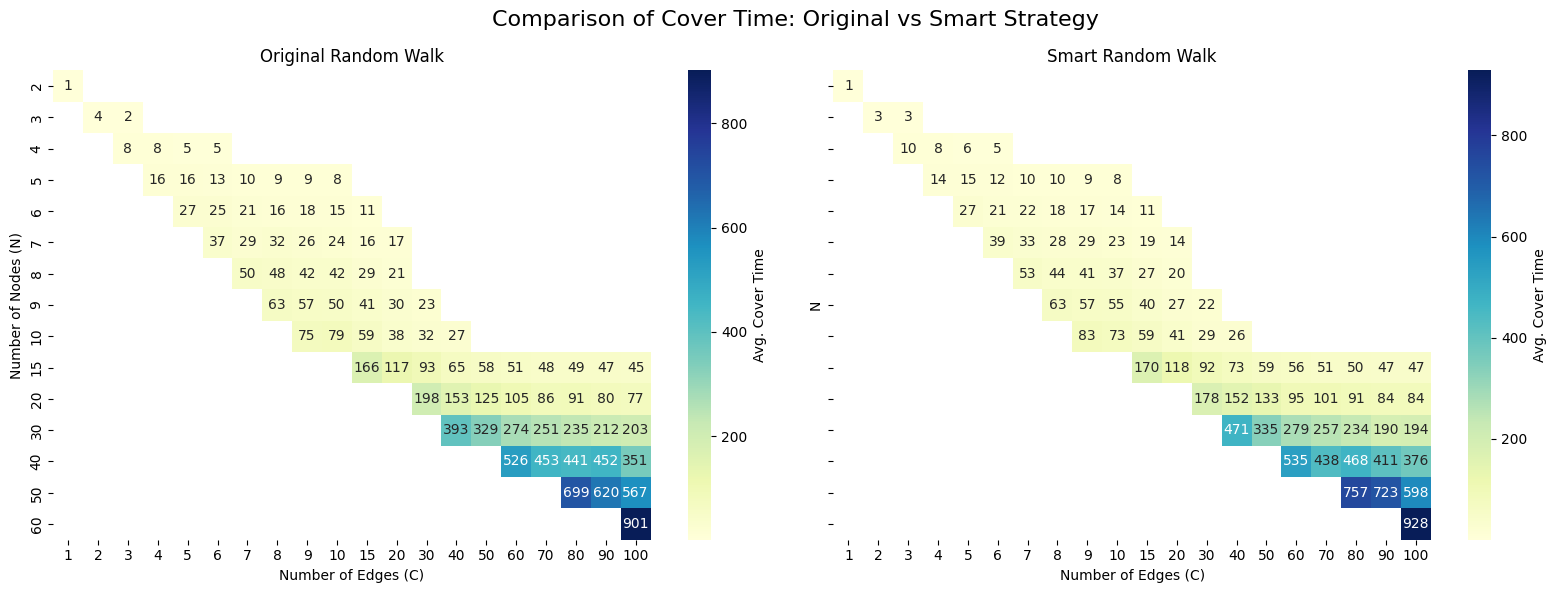

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # <-- make sure this is imported

df = pd.DataFrame(results)

# Split into two pivot tables
df_original = df[df['Strategy'] == 'original'].pivot(index='N', columns='C', values='Average Cover Time')
df_smart = df[df['Strategy'] == 'smart'].pivot(index='N', columns='C', values='Average Cover Time')

# 👇 Round down the annotations for readability
df_original_int = np.floor(df_original).where(~df_original.isna()).astype('Int64')
df_smart_int = np.floor(df_smart).where(~df_smart.isna()).astype('Int64')

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(df_original, annot=df_original_int, fmt="d", cmap="YlGnBu", ax=axes[0], cbar_kws={'label': 'Avg. Cover Time'})
axes[0].set_title("Original Random Walk")
axes[0].set_xlabel("Number of Edges (C)")
axes[0].set_ylabel("Number of Nodes (N)")

sns.heatmap(df_smart, annot=df_smart_int, fmt="d", cmap="YlGnBu", ax=axes[1], cbar_kws={'label': 'Avg. Cover Time'})
axes[1].set_title("Greedy Random Walk")
axes[1].set_xlabel("Number of Edges (C)")

plt.suptitle("Comparison of Cover Time: Original vs Greedy Strategy", fontsize=16)
plt.tight_layout()
plt.show()


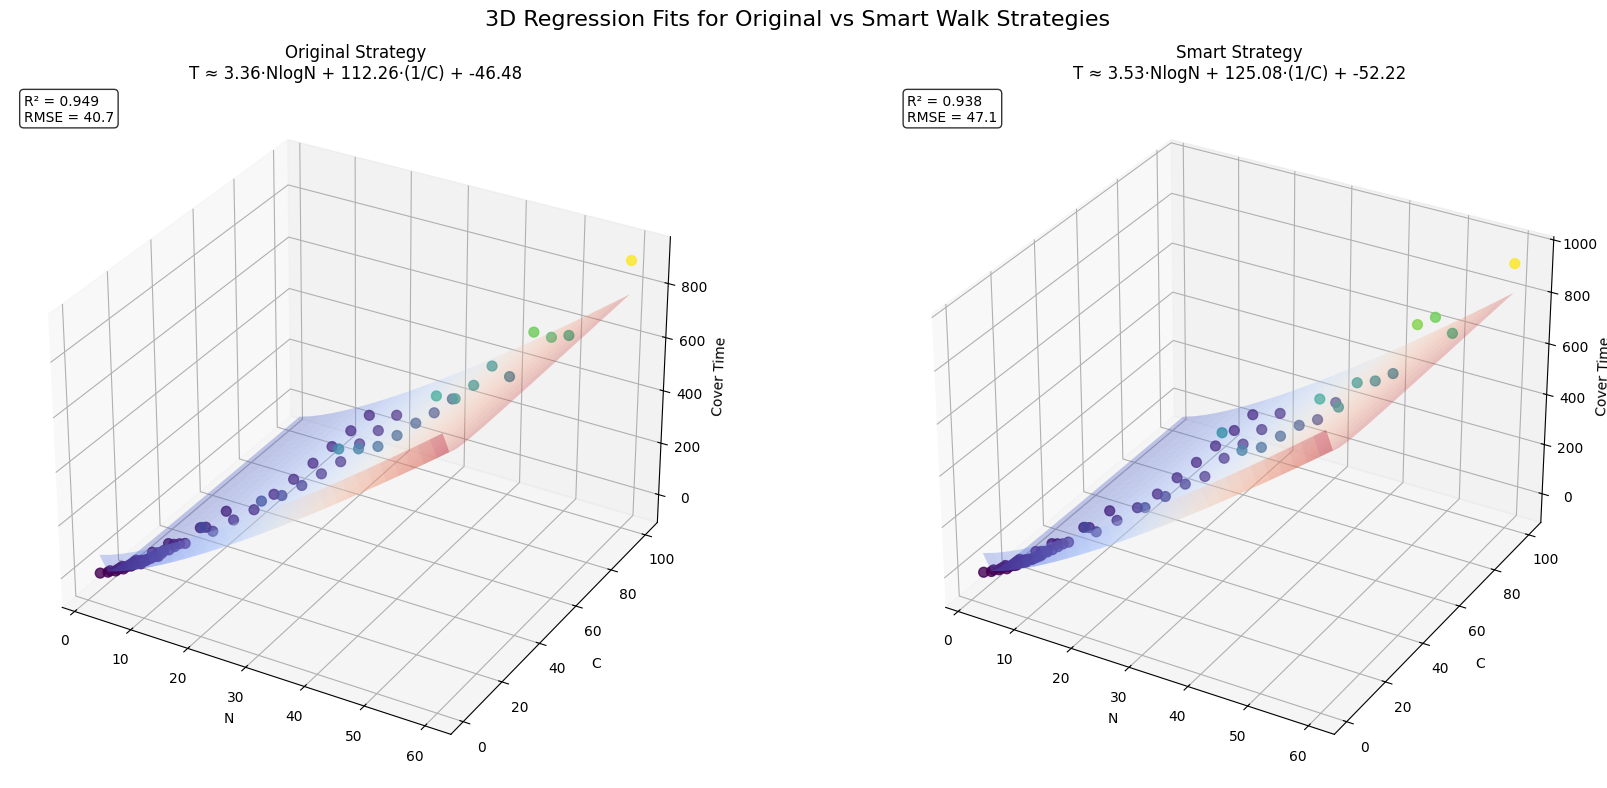

In [ ]:
fit_original = get_regression_fit(df[df['Strategy'] == 'original'])
fit_smart = get_regression_fit(df[df['Strategy'] == 'smart'])


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 8))

for i, (fit, title) in enumerate([(fit_original, 'Original Strategy'), (fit_smart, 'Greedy Strategy')]):
    if not fit:
        continue

    a, b, c = fit['coeffs']
    N_vals = fit['N']
    C_vals = fit['C']
    T_vals = fit['T']
    T_pred = fit['T_pred']

    N_lin = np.linspace(N_vals.min(), N_vals.max(), 30)
    C_lin = np.linspace(C_vals.min(), C_vals.max(), 30)
    N_grid, C_grid = np.meshgrid(N_lin, C_lin)
    Z_grid = a * (N_grid * np.log(N_grid)) + b * (1 / C_grid) + c

    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    scatter = ax.scatter(N_vals, C_vals, T_vals, c=T_vals, cmap='viridis', s=50, alpha=0.8)
    surface = ax.plot_surface(N_grid, C_grid, Z_grid, alpha=0.3, cmap='coolwarm', edgecolor='none')

    ax.set_title(f"{title}\nT ≈ {a:.2f}·NlogN + {b:.2f}·(1/C) + {c:.2f}", fontsize=12)
    ax.set_xlabel("N")
    ax.set_ylabel("C")
    ax.set_zlabel("Cover Time")
    ax.text2D(0.02, 0.95, f"R² = {fit['r2']:.3f}\nRMSE = {fit['rmse']:.1f}",
              transform=ax.transAxes, fontsize=10,
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle("3D Regression Fits for Original vs Greedy Walk Strategies", fontsize=16)
plt.tight_layout()
plt.show()

